In [4]:
from __future__ import annotations

from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from typing import Any
from carps.analysis.gather_data import interpolate_trials, process_logs

def setup_seaborn(df_trials: pd.DataFrame | None = None) -> None:
    sns.set_style("whitegrid")
    if df_trials is None:
        sns.set_palette("colorblind")
    else:
        cmap = sns.color_palette("colorblind", as_cmap=True)
        optimizers = df_trials["optimizer_id"].unique()
        palette = {o: cmap[i] for i,o in enumerate(optimizers)}
        sns.set_palette(palette)

def get_color_palette(df_trials: pd.DataFrame | None) -> dict[str, Any]:
    cmap = sns.color_palette("colorblind", as_cmap=True)
    optimizers = df_trials["optimizer_id"].unique()
    palette = {o: cmap[i] for i,o in enumerate(optimizers)}
    return palette

rundir = "/home/numina/Documents/repos/CARP-S-Experiments/lib/CARP-S/runs"

def load_logs(rundir: str):
    logs_fn = Path(rundir) / "logs.csv"
    logs_cfg_fn = logs_fn.parent / "logs_cfg.csv"

    if not logs_fn.is_file() or not logs_cfg_fn.is_file():
        msg = f"No logs found at rundir '{rundir}'. If you used the file logger, you can gather the data with `python -m carps.analysis.gather_data <rundir>`."
        raise RuntimeError(msg)

    df = pd.read_csv(logs_fn)
    df = process_logs(df)
    df_cfg = pd.read_csv(logs_cfg_fn)
    return df, df_cfg

def print_overview(df_trials: pd.DataFrame) -> None:
    print(df_trials.columns)
    print(df_trials["optimizer_id"].unique())
    print(df_trials["benchmark_id"].unique())
    print(df_trials["problem_id"].unique())
    print("Number of seeds", df_trials["seed"].nunique())


df, df_cfg = load_logs(rundir=rundir)

print_overview(df)
setup_seaborn()
palette = get_color_palette(df)

perf = interpolate_trials(df)






Index(['n_trials', 'trial_info__config', 'trial_info__instance',
       'trial_info__seed', 'trial_info__budget', 'trial_info__name',
       'trial_info__checkpoint', 'trial_value__cost', 'trial_value__time',
       'trial_value__virtual_time', 'trial_value__status',
       'trial_value__starttime', 'trial_value__endtime', 'seed',
       'benchmark_id', 'problem_id', 'optimizer_id', 'problem.bench',
       'problem.instance', 'problem.budget_type', 'problem.metric',
       'problem.dimension', 'problem.fid', 'problem.seed', 'experiment_id',
       'n_trials_norm', 'trial_value__cost_norm', 'trial_value__cost_inc',
       'trial_value__cost_inc_norm'],
      dtype='object')
['SyneTune-BO' 'SMAC3-BlackBoxFacade' 'RandomSearch']
['YAHPO' 'BBOB']
['yahpo/so/lcbench/167168/None' 'noiseless/4/1/0'
 'yahpo/so/rbv2_rpart/40499/None' 'yahpo/so/rbv2_rpart/14/None'
 'yahpo/so/rbv2_ranger/16/None' 'yahpo/so/rbv2_ranger/42/None'
 'yahpo/so/rbv2_super/1468/None' 'yahpo/so/rbv2_super/1457/None'
 'yah

In [15]:
# get final performance df
from dacbo.utils.analysis_utils import get_performance_dict

final_performance = perf[perf["n_trials_norm"]==1]



perf_dict = get_performance_dict(performance_data=final_performance, key_method="optimizer_id", key_performance="cost_inc", key_instance="problem_id")
print(final_performance["problem_id"].unique())
perf_dict["AdaptiveKernel"].shape

Lost AdaptiveDoE-EasyStopping
Lost AdaptiveDoE-SeqOdds
Lost HEBO
Lost SMAC3-BlackBoxFacade
['noiseless/10/1/0' 'noiseless/10/10/0' 'noiseless/10/11/0'
 'noiseless/10/12/0' 'noiseless/10/13/0' 'noiseless/10/14/0'
 'noiseless/10/15/0' 'noiseless/10/16/0' 'noiseless/10/17/0'
 'noiseless/10/18/0' 'noiseless/10/19/0' 'noiseless/10/2/0'
 'noiseless/10/20/0' 'noiseless/10/21/0' 'noiseless/10/22/0'
 'noiseless/10/23/0' 'noiseless/10/24/0' 'noiseless/10/3/0'
 'noiseless/10/4/0' 'noiseless/10/5/0' 'noiseless/10/6/0'
 'noiseless/10/7/0' 'noiseless/10/8/0' 'noiseless/10/9/0'
 'noiseless/5/1/0' 'noiseless/5/10/0' 'noiseless/5/11/0'
 'noiseless/5/12/0' 'noiseless/5/13/0' 'noiseless/5/14/0'
 'noiseless/5/15/0' 'noiseless/5/16/0' 'noiseless/5/17/0'
 'noiseless/5/18/0' 'noiseless/5/19/0' 'noiseless/5/2/0'
 'noiseless/5/20/0' 'noiseless/5/21/0' 'noiseless/5/22/0'
 'noiseless/5/23/0' 'noiseless/5/24/0' 'noiseless/5/3/0' 'noiseless/5/4/0'
 'noiseless/5/5/0' 'noiseless/5/6/0' 'noiseless/5/7/0' 'noiseless/5

(20, 57)

In [16]:
# Rliable
from rliable import (
    library as rly,
    metrics,
    plot_utils,
)

metric_names = ["Median", "IQM", "Mean"]#, 'Optimality Gap']

algorithms = list(perf_dict.keys())
# Load ALE scores as a dictionary mapping algorithms to their human normalized
# score matrices, each of which is of size `(num_runs x num_games)`.
aggregate_func = lambda x: np.array([
  metrics.aggregate_median(x),
  metrics.aggregate_iqm(x),
  metrics.aggregate_mean(x),
  #metrics.aggregate_optimality_gap(x)
  ])
aggregate_scores, aggregate_score_cis = rly.get_interval_estimates(
  perf_dict, aggregate_func, reps=5000)

# with open(f'perf_dict_{benchmark_id}.pickle', 'wb') as handle:
#     pickle.dump(perf_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
# with open(f'aggregate_scores_{benchmark_id}.pickle', 'wb') as handle:
#     pickle.dump(aggregate_scores, handle, protocol=pickle.HIGHEST_PROTOCOL)
# with open(f'aggregate_score_cis_{benchmark_id}.pickle', 'wb') as handle:
#     pickle.dump(aggregate_score_cis, handle, protocol=pickle.HIGHEST_PROTOCOL)

[10:27:59] INFO     Calculating estimates for AdaptiveDoE-37 ...                                     ]8;id=682587;file:///home/numina/micromamba/envs/dacbo/lib/python3.11/site-packages/rliable/library.py\library.py]8;;\:]8;id=552507;file:///home/numina/micromamba/envs/dacbo/lib/python3.11/site-packages/rliable/library.py#270\270]8;;\

[10:28:00] INFO     Calculating estimates for AdaptiveKernel ...                                     ]8;id=434169;file:///home/numina/micromamba/envs/dacbo/lib/python3.11/site-packages/rliable/library.py\library.py]8;;\:]8;id=171116;file:///home/numina/micromamba/envs/dacbo/lib/python3.11/site-packages/rliable/library.py#270\270]8;;\

[10:28:01] INFO     Calculating estimates for AdaptiveKernel-Random ...                              ]8;id=187751;file:///home/numina/micromamba/envs/dacbo/lib/python3.11/site-packages/rliable/library.py\library.py]8;;\:]8;id=25780;file:///home/numina/micromamba/envs/dacbo/lib/python3.11/site-packages/rliable/library.py#270\270]8;;\

           INFO     Calculating estimates for RandomSearch ...                                       ]8;id=462255;file:///home/numina/micromamba/envs/dacbo/lib/python3.11/site-packages/rliable/library.py\library.py]8;;\:]8;id=282225;file:///home/numina/micromamba/envs/dacbo/lib/python3.11/site-packages/rliable/library.py#270\270]8;;\

KeyError: 'AdaptiveDoE-EasyStopping'

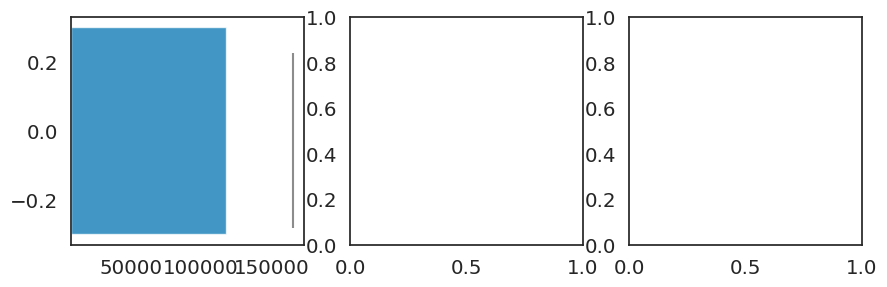

In [17]:
sns.set_style("white")

algos = final_performance["optimizer_id"].unique()

fig, axes = plot_utils.plot_interval_estimates(
  aggregate_scores, aggregate_score_cis,
  metric_names=metric_names,
  algorithms=algos, xlabel="Performance",
  xlabel_y_coordinate=-0.6
)
fig.savefig("plot_rliable.pdf", dpi=300, bbox_inches="tight")

fig, axes = plot_utils.plot_interval_estimates(
  aggregate_scores, aggregate_score_cis,
  metric_names=metric_names,
  algorithms=algorithms, xlabel="Performance",
  xlabel_y_coordinate=0.025
)
fig.savefig("plot_rliable_all.pdf", dpi=300, bbox_inches="tight")

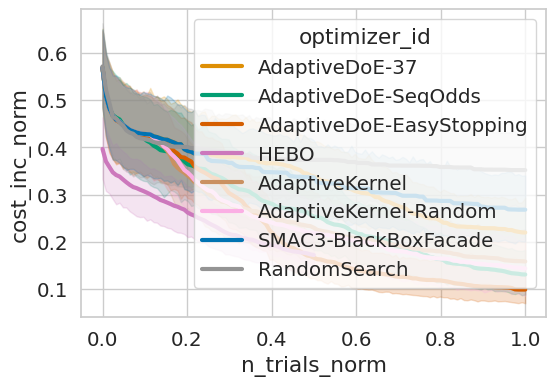

In [18]:
sns.set(font_scale=1.3)
sns.set_style("whitegrid")
sns.set_palette("colorblind")
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(111)
ax = sns.lineplot(data=df[df["dim"]==5], x="n_trials_norm", y="cost_inc_norm", hue="optimizer_id", ax=ax, linewidth=3, palette=palette)
fig.savefig("performance_over_time_5d.png", dpi=300, bbox_inches="tight")

<Axes: xlabel='n_trials_norm', ylabel='cost_inc_norm'>

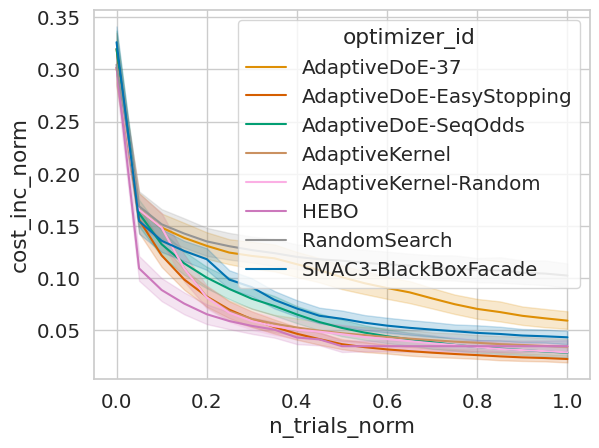

In [19]:
sns.lineplot(data=perf, x="n_trials_norm", y="cost_inc_norm", hue="optimizer_id", palette=palette)

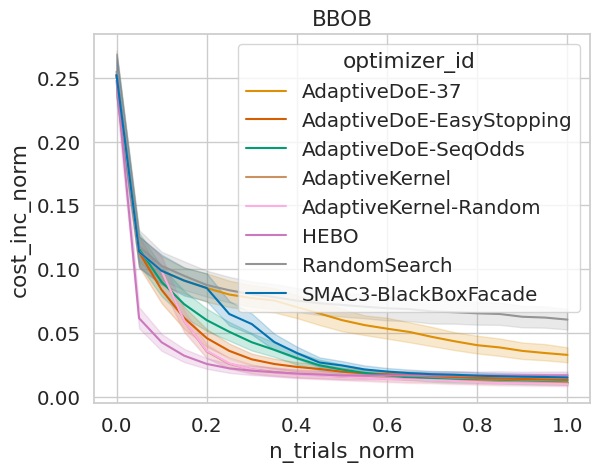

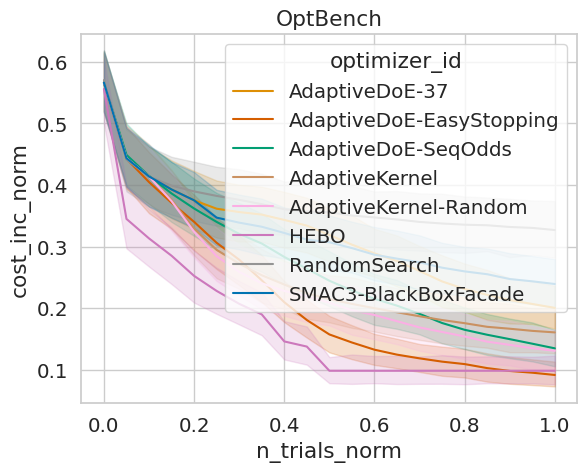

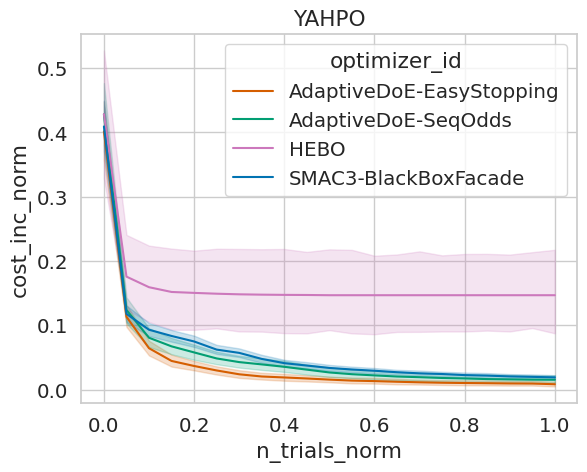

In [20]:
for gid, gdf in perf.groupby(by="benchmark_id"):
    ax = sns.lineplot(data=gdf, x="n_trials_norm", y="cost_inc_norm", hue="optimizer_id", palette=palette)
    ax.set_title(gid)
    plt.show()

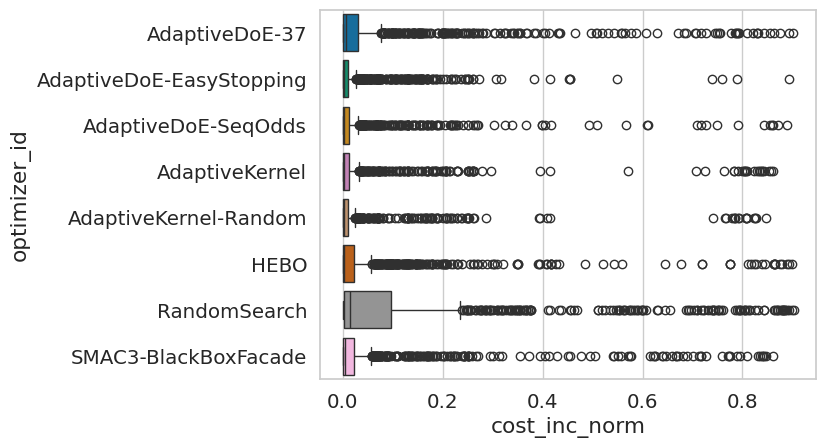

In [ ]:
ax = sns.boxplot(data=perf[perf["n_trials_norm"]==1], y="optimizer_id", x="cost_inc_norm", hue="optimizer_id", palette=palette)

In [21]:
max_val = df["n_trials_norm"].max()
error = df.groupby(by=["benchmark_id", "problem_id", "optimizer_id", "seed"])["n_trials_norm"].apply(lambda x: not np.isclose(x.max(), max_val))
error = error[error]
for i in error.index:
    print(i)

('BBOB', 'noiseless/10/1/0', 'HEBO', 1)
('BBOB', 'noiseless/10/1/0', 'HEBO', 2)
('BBOB', 'noiseless/10/1/0', 'HEBO', 3)
('BBOB', 'noiseless/10/1/0', 'HEBO', 4)
('BBOB', 'noiseless/10/1/0', 'HEBO', 5)
('BBOB', 'noiseless/10/1/0', 'HEBO', 6)
('BBOB', 'noiseless/10/1/0', 'HEBO', 7)
('BBOB', 'noiseless/10/1/0', 'HEBO', 8)
('BBOB', 'noiseless/10/1/0', 'HEBO', 9)
('BBOB', 'noiseless/10/1/0', 'HEBO', 10)
('BBOB', 'noiseless/10/1/0', 'HEBO', 11)
('BBOB', 'noiseless/10/1/0', 'HEBO', 12)
('BBOB', 'noiseless/10/1/0', 'HEBO', 13)
('BBOB', 'noiseless/10/1/0', 'HEBO', 14)
('BBOB', 'noiseless/10/1/0', 'HEBO', 15)
('BBOB', 'noiseless/10/1/0', 'HEBO', 16)
('BBOB', 'noiseless/10/1/0', 'HEBO', 17)
('BBOB', 'noiseless/10/1/0', 'HEBO', 18)
('BBOB', 'noiseless/10/1/0', 'HEBO', 19)
('BBOB', 'noiseless/10/1/0', 'HEBO', 20)
('BBOB', 'noiseless/10/10/0', 'HEBO', 1)
('BBOB', 'noiseless/10/10/0', 'HEBO', 2)
('BBOB', 'noiseless/10/10/0', 'HEBO', 3)
('BBOB', 'noiseless/10/10/0', 'HEBO', 4)
('BBOB', 'noiseless/10/10

0.999999999962406